In [1]:
# general tools
import os
import sys
import time
import h5py
import random
from glob import glob

import numpy as np
from random import shuffle

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend
from keras_unet_collection import utils as k_utils

2022-11-01 11:55:59.142492: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import confusion_matrix

In [5]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

In [6]:
def create_model():

    IN = keras.Input((768,))

    X = IN

    X = keras.layers.Dense(1024, activity_regularizer=keras.regularizers.L2(1e-2))(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation("gelu")(X)

    X = keras.layers.Dropout(0.3)(X)
    #X = keras.layers.GaussianDropout(0.1)(X)

    X = keras.layers.Dense(512, activity_regularizer=keras.regularizers.L2(1e-2))(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation("gelu")(X)

    X = keras.layers.Dropout(0.3)(X)
    #X = keras.layers.GaussianDropout(0.1)(X)

    X = keras.layers.Dense(128, activity_regularizer=keras.regularizers.L2(1e-2))(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation("gelu")(X)

    X = keras.layers.Dropout(0.3)(X)

    X = keras.layers.Dense(64, activity_regularizer=keras.regularizers.L2(1e-2))(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation("gelu")(X)

    OUT = X
    OUT = keras.layers.Dense(1, activation='sigmoid', bias_initializer=keras.initializers.Constant(-10))(OUT)

    model = keras.models.Model(inputs=IN, outputs=OUT)
    
    return model

In [7]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'HEAD_Lead2'

### Data prep

In [8]:
filename_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/VALID*neg_neg_neg*lead2.npy")) + \
                 sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/VALID*pos*lead2.npy"))

data_p_valid = np.load('/glade/work/ksha/NCAR/TEST_pred_lead2_vec2.npy', allow_pickle=True)[()]

filename_test = filename_valid + \
                sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v4/*neg_neg_neg*lead{}.npy".format(2))) + \
                sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v4/*pos*lead{}.npy".format(2)))

data_p_test = np.load('/glade/work/ksha/NCAR/TEST_pred_lead2_v4_vec2.npy', allow_pickle=True)[()]

TEST_256 = np.concatenate((data_p_valid['y_vector'], data_p_test['y_vector']), axis=0)
TEST_pred = np.concatenate((data_p_valid['y_pred'], data_p_test['y_pred']), axis=0)
TEST_Y = np.concatenate((data_p_valid['y_true'], data_p_test['y_true']), axis=0)

In [9]:
ix = 30
iy = 55

name_block5 = []

for i in range(ix-2, ix+3):
    for j in range(iy-2, iy+3):
        name_block5.append('indx{}_indy{}'.format(i, j))

In [10]:
def pick_files(filename, name_pattern):
    L_test = len(filename)
    flag_pick_test = [False,]*L_test
    filename_pick_test = []

    for i, name in enumerate(filename):
        for patterns in name_pattern:
            if patterns in name:
                flag_pick_test[i] = True
                filename_pick_test.append(name)
                break;
                
    return filename_pick_test, flag_pick_test


In [11]:
filename_test_pick, flag_pick_test = pick_files(filename_test, name_block5)

### Check model existence

In [12]:
from pathlib import Path

In [13]:
with h5py.File(save_dir+'HRRR_domain.hdf', 'r') as h5io:
    lon_80km = h5io['lon_80km'][...]
    lat_80km = h5io['lat_80km'][...]
    land_mask_80km = h5io['land_mask_80km'][...]
    
grid_shape = land_mask_80km.shape

In [14]:
L = 25*len(filename_test)

In [15]:
BS = np.empty(grid_shape)
BSS = np.empty(grid_shape)
BS_ref = np.empty(grid_shape)

PRED = np.empty((L,))
TRUE = np.empty((L,))

BS[...] = np.nan
BSS[...] = np.nan
BS_ref[...] = np.nan

PRED[...] = np.nan
TRUE[...] = np.nan

In [17]:
count = 0
list_bad = [(23, 61), (24, 63), (25, 64), (26, 50), (30, 61)]
for ix in range(grid_shape[0]):
    for iy in range(grid_shape[1]):
        if land_mask_80km[ix, iy]:
            if (ix, iy) in list_bad:
                continue;
            
            model_name = '{}_ix{}_iy{}'.format(key, ix, iy)
            model_path = temp_dir+model_name
            path_io = Path(model_path)
            flag_model = path_io.is_dir()
            
            if flag_model:
                #print('Verif ix:{}, iy:{}'.format(ix, iy))
                
                model = create_model()
                W_old = k_utils.dummy_loader(model_path)
                try:
                    model.set_weights(W_old)
                except:
                    print("Old model, skip")
                    continue;

                name_block5 = []

                for i in range(ix-2, ix+3):
                    for j in range(iy-2, iy+3):
                        name_block5.append('indx{}_indy{}'.format(i, j))
                        
                filename_test_pick, flag_pick_test = pick_files(filename_test, name_block5)
                
                TEST_256_pick = TEST_256[flag_pick_test, :]
                TEST_pred_pick = TEST_pred[flag_pick_test, :]
                TEST_Y_pick = TEST_Y[flag_pick_test]
                
                Y_pred = model.predict([TEST_256_pick])
                Y_pred = Y_pred[:, 0]
                
                bs = np.mean((TEST_Y_pick.ravel() - Y_pred.ravel())**2)
                bs_ref = np.sum(TEST_Y_pick) / len(TEST_Y_pick)
                
                bss = (bs_ref-bs)/(bs_ref)
                
                #out[:, ix, iy] = Y_pred
                BS[ix, iy] = bs
                BSS[ix, iy] = bss
                BS_ref[ix, iy] = bs_ref
                
                L_temp = len(Y_pred)
                PRED[count:count+L_temp] = Y_pred
                TRUE[count:count+L_temp] = TEST_Y_pick
                count += L_temp
                
                print('ix:{}, iy:{}, BSS: {}'.format(ix, iy, bss))
     

ix:19, iy:46, BSS: 0.07932236178113228
ix:19, iy:47, BSS: 0.07518270766162519
ix:19, iy:48, BSS: 0.07126175935542148
ix:19, iy:49, BSS: 0.07332056381800554
ix:19, iy:50, BSS: 0.07023086715963554
ix:20, iy:45, BSS: 0.0620743872127276
ix:20, iy:46, BSS: 0.1088444001839845
ix:20, iy:47, BSS: 0.11695337518485083
ix:20, iy:48, BSS: 0.10840589149095986
ix:20, iy:49, BSS: 0.10670595200988472
ix:20, iy:50, BSS: 0.13021506899812674
ix:21, iy:44, BSS: 0.07495455202494038
ix:21, iy:45, BSS: 0.057536135070761156
ix:21, iy:46, BSS: 0.087065795435816
ix:21, iy:47, BSS: 0.08801706484877296
ix:21, iy:48, BSS: 0.09020891608284878
ix:21, iy:49, BSS: 0.09680307306324679
ix:21, iy:50, BSS: 0.10823699126518105
ix:21, iy:51, BSS: 0.09142170852982953
ix:21, iy:52, BSS: 0.09842185586635989
ix:21, iy:53, BSS: 0.1041777379958638
ix:21, iy:54, BSS: 0.10492047713819153
ix:21, iy:55, BSS: 0.11617588857976603
ix:21, iy:56, BSS: 0.16487749929521792
ix:21, iy:57, BSS: 0.14046514910130753
ix:22, iy:43, BSS: 0.12532847

In [18]:
TRUE = TRUE[:count]
PRED = PRED[:count]

In [19]:
y_true = TRUE
y_pred = PRED

fpr, tpr, thres = roc_curve(y_true, y_pred)
o_bar = np.mean(y_true)

bs = brier_score_loss(y_true, y_pred)
auc_score = auc(fpr, tpr)
bss = (o_bar-bs)/(o_bar)

print('auc: {}'.format(auc_score))
print('o_bar: {}'.format(o_bar))
print('bs: {}'.format(bs))
print('bss: {}'.format(bss))

auc: 0.9658515233152931
o_bar: 0.002447066663313803
bs: 0.002198434337535185
bss: 0.10160423069223687


In [20]:
np.nanmean(BSS)

0.1016167947733466

In [21]:
from sklearn.calibration import calibration_curve

In [26]:
prob_true, prob_pred = calibration_curve(TRUE, PRED, n_bins=25)

Text(0.1, 0.85, 'BSS = 0.1016\nAUC = 0.9658')

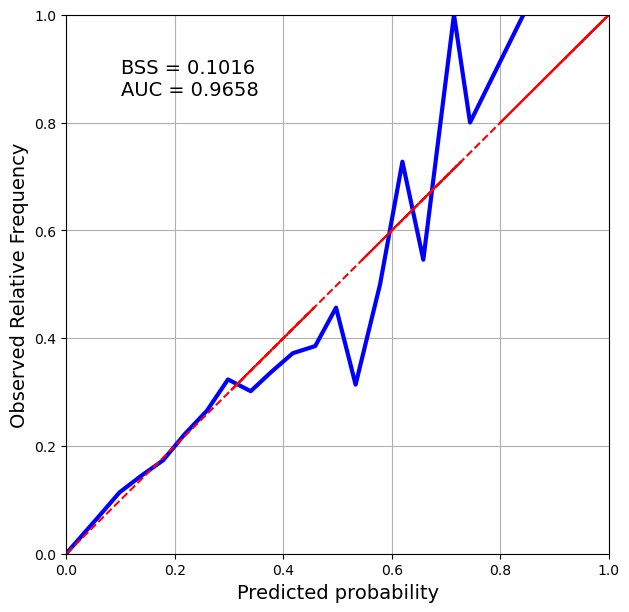

In [27]:
plt.figure(figsize=(7, 7))
plt.plot(prob_pred, prob_true, 'b-', lw=3)
plt.plot(prob_true, prob_true, 'r--')
plt.grid()
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.xlabel('Predicted probability', fontsize=14)
plt.ylabel('Observed Relative Frequency', fontsize=14)

plt.text(0.1, 0.85, 'BSS = 0.1016\nAUC = 0.9658', fontsize=14)

/glade/scratch/ksha/ipykernel_171052/365276647.py:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  CS = plt.pcolormesh(lon_80km[15:52, 17:80], lat_80km[15:52, 17:80], BSS[15:52, 17:80], cmap=plt.cm.nipy_spectral_r)


Text(0.5, 1.0, 'BSS on individual locations\nBlank means (1) insufficient data\n(2) classifier training in progress')

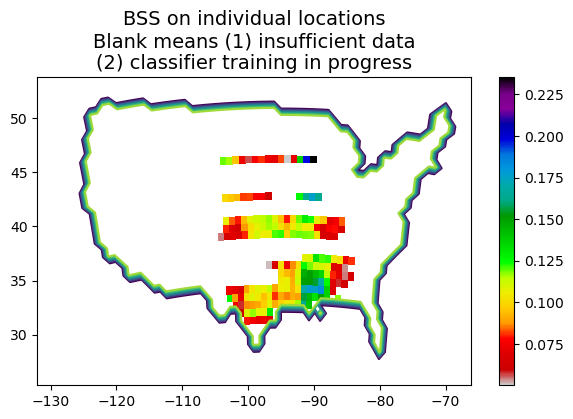

In [31]:
plt.figure(figsize=(7, 4))
CS = plt.pcolormesh(lon_80km[15:52, 17:80], lat_80km[15:52, 17:80], BSS[15:52, 17:80], cmap=plt.cm.nipy_spectral_r)
plt.contour(lon_80km[15:52, 17:80], lat_80km[15:52, 17:80], land_mask_80km[15:52, 17:80])
plt.colorbar(CS)

plt.title('BSS on individual locations\nBlank means (1) insufficient data\n(2) classifier training in progress', fontsize=14)

In [40]:
def performance_diagram_calc(y_true, y_pred_calib, N=50):
    thres = np.linspace(0.01, 0.75, N)
    pod = np.empty(N)
    sr = np.empty(N)

    for i, thre in enumerate(thres):
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred_calib>thre).ravel()
        pod[i] = tp / (tp + fn)

        if fp + tp > 1:
            sr[i] = tp / (fp + tp)
        else:
            sr[i] = np.nan
            
    return sr, pod

In [41]:
sr_t, pod_t = performance_diagram_calc(TRUE, PRED, N=50)

Text(0.5, 1.0, 'Performance diagram with thresholds of (0, 0.75]')

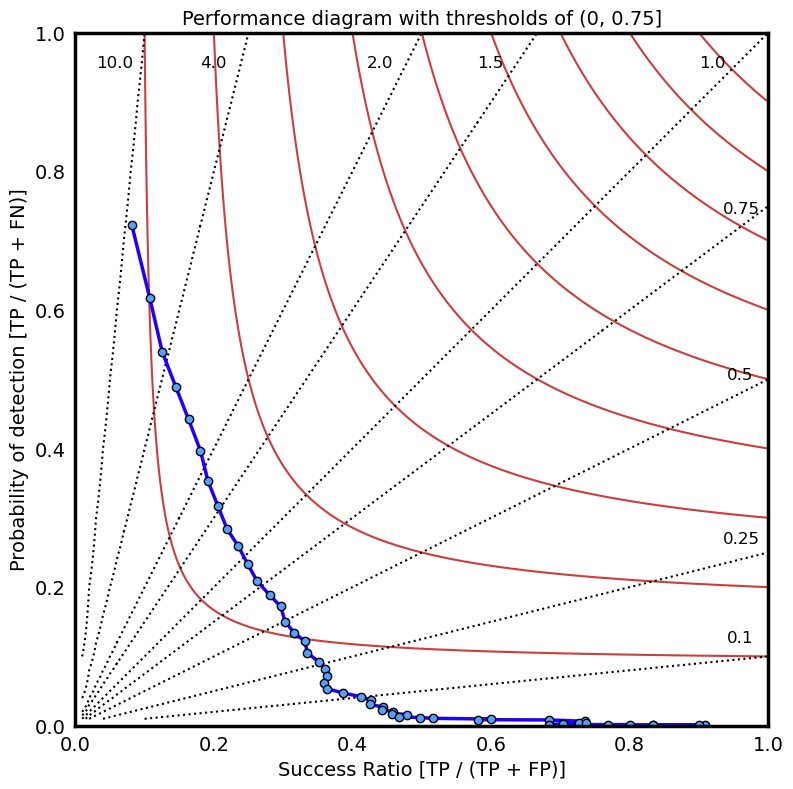

In [42]:
fig = plt.figure(figsize=(9, 9))
ax = fig.gca()

ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

ax = gu.ax_decorate_box(ax)
ax.tick_params(axis="both", which="both", labelbottom=True, labelleft=True)

ax.set_aspect('equal')

x_axis = np.arange(0.01, 1.01, 0.01)
y_axis = np.arange(0.01, 1.01, 0.01)
x_mesh, y_mesh = np.meshgrid(x_axis, y_axis)

csi = ((1 / x_mesh) + (1 / y_mesh) - 1) ** -1
cs_ = ax.contour(x_mesh, y_mesh, csi, np.arange(0.0, 1.1, 0.1), colors=(red,), linestyles='-')

biases = [0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 4.0, 10.0]
bias_loc_x = [0.94, 0.935, 0.94, 0.935, 0.9, 0.58, 0.42, 0.18, 0.03]
bias_loc_y = [0.12, 0.2625, 0.5, 0.74, 0.95, 0.95, 0.95, 0.95, 0.95]
bias = y_mesh / x_mesh

ax.contour(x_mesh, y_mesh, bias, biases, colors='k', linestyles=':')

for i, label in enumerate(biases):
    ax.annotate(label, (bias_loc_x[i], bias_loc_y[i]), fontsize=12)

ax.plot(sr_t, pod_t, 'o-', color=blue, linewidth=2.5, ms=6, mec='k', mfc=cyan)
#ax.plot(sr_v, pod_v, 'o-', color=blue, linewidth=2.5, ms=6, mec='k', mfc=blue)


#ax.text(0.1, 0.70, 'Test', ha='right', va='bottom', color=red, fontsize=14, fontweight='bold', transform=ax.transAxes)
#ax.text(0.1, 0.65, 'Valid', ha='right', va='bottom', color=blue, fontsize=14, fontweight='bold', transform=ax.transAxes)

ax.set_xlabel('Success Ratio [TP / (TP + FP)]', fontsize=14)
ax.set_ylabel('Probability of detection [TP / (TP + FN)]', fontsize=14)

ax.set_title('Performance diagram with thresholds of (0, 0.75]', fontsize=14)

In [38]:
blue

array([0.11372549, 0.        , 1.        , 1.        ])